<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import nltk
import re
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel as LDA

from matplotlib import pyplot as plt

In [2]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class SimpleTopicalLM:
  """
  Word-level Topical Language Model using LDA as a topic model, and n-gram
    language models.
  """
  def __init__(self, num_topics, window=3, filter_stopwords=True, 
               stopwords=None, filter_nonalpha=True, lower=True, 
               min_doc_length=2):
    self.num_topics = num_topics
    self.window = window
    self.filter_stopwords = filter_stopwords
    self.filter_nonalpha = filter_nonalpha
    self.min_doc_length = min_doc_length
    self.lower = lower
    if stopwords is None:
      self.stopwords = {'a', 'about', 'above', 'after', 'again', 'against', 
                        'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 
                        "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 
                        'being', 'below', 'between', 'both', 'but', 'by', 'can', 
                        'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 
                        'do', 'does', 'doesn', "doesn't", 'doing', 'don', 
                        "don't", 'down', 'during', 'each', 'few', 'for', 'from', 
                        'further', 'had', 'hadn', "hadn't", 'has', 'hasn', 
                        "hasn't", 'have', 'haven', "haven't", 'having', 'he', 
                        'her', 'here', 'hers', 'herself', 'him', 'himself', 
                        'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', 
                        "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 
                        'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 
                        'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 
                        'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 
                        'once', 'only', 'or', 'other', 'our', 'ours', 
                        'ourselves', 'out', 'over', 'own', 're', 's', 'same', 
                        'shan', "shan't", 'she', "she's", 'should', "should've", 
                        'shouldn', "shouldn't", 'so', 'some', 'such', 't', 
                        'than', 'that', "that'll", 'the', 'their', 'theirs', 
                        'them', 'themselves', 'then', 'there', 'these', 'they', 
                        'this', 'those', 'through', 'to', 'too', 'under', 
                        'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 
                        'we', 'were', 'weren', "weren't", 'what', 'when', 
                        'where', 'which', 'while', 'who', 'whom', 'why', 'will', 
                        'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 
                        'you', "you'd", "you'll", "you're", "you've", 'your', 
                        'yours', 'yourself', 'yourselves'}
    else:
      self.stopwords = stopwords

  def clean(self, documents):
    cleaned_docs = [d for d in documents]

    if self.filter_nonalpha:
      cleaned_docs = [[w for w in d if re.match(r'^[a-z]+$',w)] for d in cleaned_docs]
    if self.filter_stopwords:
      cleaned_docs = [[w for w in d if w not in self.stopwords] for d in cleaned_docs]
    if self.lower:
      cleaned_docs = [[w.lower() for w in d] for d in cleaned_docs]

    return cleaned_docs


  def fit(self, documents, verbose=0):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    if verbose > 0:
      print('Cleaning documents for LDA.')

    cleaned_docs = self.clean(documents)
    cleaned_docs = [d for d in documents if len(d)>= self.min_doc_length]

    if verbose > 0:
      print('Fitting LDA.')

    indexer = Dictionary(cleaned_docs)
    bow = [indexer.doc2bow(d) for d in cleaned_docs]
    self.topic_model = LDA(bow, num_topics=self.num_topics, id2word=indexer)

    if verbose > 0:
      print('Fitting {}-gram language models'.format(self.window))

    ngram_counts = [dict() for t in range(self.num_topics)]
    ngram_tots = [dict() for t in range(self.num_topics)]
    for k, d in enumerate(documents):
      if verbose > 1 and k%100==0:
        print('\rcounting document {}'.format(k), end='')
      for t in range(self.num_topics):
        topic_dist = dict(self.topic_model[indexer.doc2bow(d)])
        topic_dist = [topic_dist.get(k,0) for k in range(self.num_topics)]
        tot = sum(topic_dist)
        topic_dist = [p/tot for p in topic_dist]
        d_pad = ['<start>']*(self.window-1)+d+['<end>']
        for gram in multiples(d_pad, self.window):
          key = ' '.join(gram[:-1])
          word = gram[-1]
          ngram_tots[t][key] = ngram_tots[t].get(key, 0) + topic_dist[t]
          if key in ngram_counts[t]:
            ngram_counts[t][key][word] = ngram_counts[t][key].get(word,0) + topic_dist[t]
          else:
            ngram_counts[t][key] = {word:topic_dist[t]}

    self.ngram_probs = [dict() for t in range(self.num_topics)]
    for t in range(self.num_topics):
      for key in ngram_counts[t].keys():
        self.ngram_probs[t][key] = []
        for word in ngram_counts[t][key].keys():
          p_tot = ngram_tots[t][key]
          if p_tot > 0:
            self.ngram_probs[t][key].append((word, ngram_counts[t][key][word]/p_tot))

  def predict(self, init_doc, topic, method='sample'):
    pad_doc = ['<start>']*(self.window-1) + init_doc
    key = ' '.join(pad_doc[-self.window+1:])
    if method == 'sample':
      return np.random.choice([w for w,p in self.ngram_probs[topic][key]],
                              p=[p for w,p in self.ngram_probs[topic][key]])
    elif method == 'max':
      return self.ngram_probs[topic][key][np.argmax([p for w,p in self.ngram_probs[topic][key]])][0]

    elif method == 'distribution':
      return self.ngram_probs[topic][key]

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '<end>': break
      init_doc.append(predicted)

    return init_doc

  def get_topics(self, doc):
    cleaned = self.clean([doc])[0]
    bow = self.topic_model.id2word.doc2bow(cleaned)
    return [dict(self.topic_model[bow]).get(k,0) for k in range(self.num_topics)]

In [0]:
thurs = nltk.corpus.gutenberg.sents('chesterton-thursday.txt')
hamlet = nltk.corpus.gutenberg.sents('shakespeare-hamlet.txt')

docs = [('thurs', d) for d in thurs]
docs.extend([('hamlet', d) for d in hamlet])

p = np.random.permutation(np.arange(len(docs)))
docs = [docs[k] for k in p]

In [48]:
stlm = SimpleTopicalLM(num_topics=2)
stlm.fit([d for t, d in docs[:4000]], verbose=2)

Cleaning documents for LDA.
Fitting LDA.
Fitting 3-gram language models
counting document 3900

In [49]:
docs[4000][0], ' '.join(docs[4000][1])

('thurs',
 'He walked up to a long mirror with the ordinary instinct of his class , to pull his tie straight or to smooth his hair ; and there he saw the frightful figure that he was -- blood running down his face from where the bough had struck him , his hair standing out like yellow rags of rank grass , his clothes torn into long , wavering tatters .')

In [50]:
stlm.get_topics(docs[4000][1])

[0.8137511, 0.18625888]

In [67]:
' '.join(stlm.rollout([], topic=0, method='monte-carlo'))

'To the Celestiall , and then smaller with distance , and I rattled in my heart : but thou wouldest flye death .'

In [61]:
' '.join(stlm.rollout([], topic=1, method='monte-carlo'))

'Yet he rambled and dodged for a my behoue , O me thought there were other touches .'

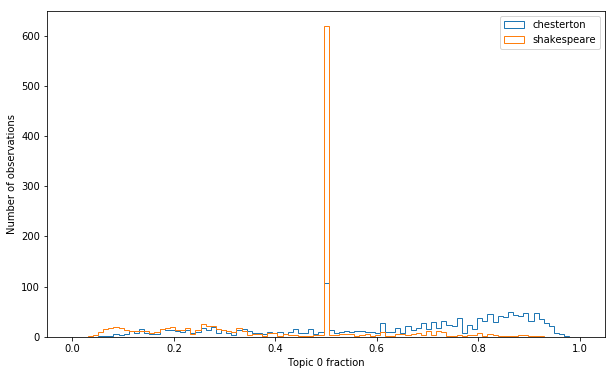

In [53]:
thurs_preds = [stlm.get_topics(d)[0] for t,d in docs[4000:] if t == 'thurs']
hamlet_preds = [stlm.get_topics(d)[0] for t,d in docs[4000:] if t == 'hamlet']

fig, ax = plt.subplots()
ax.hist(thurs_preds, bins = np.linspace(0,1,100), histtype='step', label='chesterton')
ax.hist(hamlet_preds, bins=np.linspace(0,1,100), histtype='step', label='shakespeare')

ax.legend()
ax.set_xlabel('Topic 0 fraction')
ax.set_ylabel('Number of observations')

fig.set_size_inches(10,6)
plt.show()